In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import ydata_profiling
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet

# これで確実に警告を消せる
import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv("/Users/yoshitakanishikawa/Downloads/assignment-main/Trainee/time-series-prediction/stock_price.csv")


In [29]:
def convert_volume_with_apply(volume_str):
    """
    出来高の文字列を数値に変換する関数
    applyで使用する
    """
    if pd.isna(volume_str):
        return np.nan

    volume_str = str(volume_str)

    # 右端の文字で単位を判定
    last_char = volume_str[-1]

    if last_char == 'M':  # ミリオン
        return float(volume_str[:-1]) * 1_000_000
    elif last_char == 'B':  # ビリオン
        return float(volume_str[:-1]) * 1_000_000_000
    elif last_char == 'K':  # キロ
        return float(volume_str[:-1]) * 1_000
    else:  # 単位なし
        return float(volume_str)

In [30]:
df["出来高"].str[-1].unique()
df['出来高'] = df['出来高'].apply(convert_volume_with_apply)

df["変化率 %"] = df["変化率 %"].str.replace("%", "").astype(float) / 100


In [31]:
#日付け列をdatetime型に変換
df["日付け"] = pd.to_datetime(df["日付け"])
print(df.dtypes)

日付け      datetime64[ns]
終値              float64
始値              float64
高値              float64
安値              float64
出来高             float64
変化率 %           float64
dtype: object


In [32]:
#日付を並び替え
df = df.sort_values("日付け", ascending=True).reset_index(drop=True)

In [33]:
start_date = df["日付け"].min()
end_date = df["日付け"].max()
sample_dates = pd.date_range(start=start_date, end=end_date)

df_dates_set = set(df["日付け"])

# sample_datesにあるが、df_dates_setにはない日付をリスト化
missing_dates = [date for date in sample_dates if date not in df_dates_set]

# 結果を表示
if len(missing_dates) > 0:
    print("以下の日付が欠損しています:")
    for date in missing_dates:
        print(date)
else:
    print("欠損している日付はありません。")

print(f"\n欠損の日付count : {len(missing_dates)}")

以下の日付が欠損しています:
1987-02-14 00:00:00
1987-02-15 00:00:00
1987-02-21 00:00:00
1987-02-22 00:00:00
1987-02-28 00:00:00
1987-03-01 00:00:00
1987-03-07 00:00:00
1987-03-08 00:00:00
1987-03-14 00:00:00
1987-03-15 00:00:00
1987-03-21 00:00:00
1987-03-22 00:00:00
1987-03-28 00:00:00
1987-03-29 00:00:00
1987-04-04 00:00:00
1987-04-05 00:00:00
1987-04-11 00:00:00
1987-04-12 00:00:00
1987-04-18 00:00:00
1987-04-19 00:00:00
1987-04-25 00:00:00
1987-04-26 00:00:00
1987-04-29 00:00:00
1987-05-02 00:00:00
1987-05-03 00:00:00
1987-05-04 00:00:00
1987-05-05 00:00:00
1987-05-09 00:00:00
1987-05-10 00:00:00
1987-05-16 00:00:00
1987-05-17 00:00:00
1987-05-23 00:00:00
1987-05-24 00:00:00
1987-05-30 00:00:00
1987-05-31 00:00:00
1987-06-06 00:00:00
1987-06-07 00:00:00
1987-06-13 00:00:00
1987-06-14 00:00:00
1987-06-20 00:00:00
1987-06-21 00:00:00
1987-06-27 00:00:00
1987-06-28 00:00:00
1987-07-04 00:00:00
1987-07-05 00:00:00
1987-07-11 00:00:00
1987-07-12 00:00:00
1987-07-18 00:00:00
1987-07-19 00:00:00
1987-

In [34]:
df.describe()

,日付け,終値,始値,高値,安値,出来高,変化率 %
count,9202,9202.000000,9202.000000,9202.000000,9202.000000,9.202000e+03,9202.000000
mean,2005-10-21 08:44:04.642468992,92.180961,92.256183,93.176451,91.330146,1.726677e+08,0.000175
min,1987-02-12 00:00:00,33.000000,33.000000,33.200000,32.200000,9.340000e+06,-0.147400
25%,1996-06-06 06:00:00,52.000000,52.100000,52.800000,51.500000,8.073000e+07,-0.009400
50%,2005-10-11 12:00:00,85.100000,85.100000,86.050000,84.200000,1.540150e+08,0.000000
75%,2015-03-04 18:00:00,110.800000,110.800000,111.900000,109.275000,2.305225e+08,0.009000
max,2024-08-01 00:00:00,305.900000,309.800000,311.800000,303.900000,1.280000e+09,0.162500
std,NaN,50.452228,50.598215,51.049837,50.087405,1.251280e+08,0.018767


In [35]:
#ydata_profiling.ProfileReport(df)

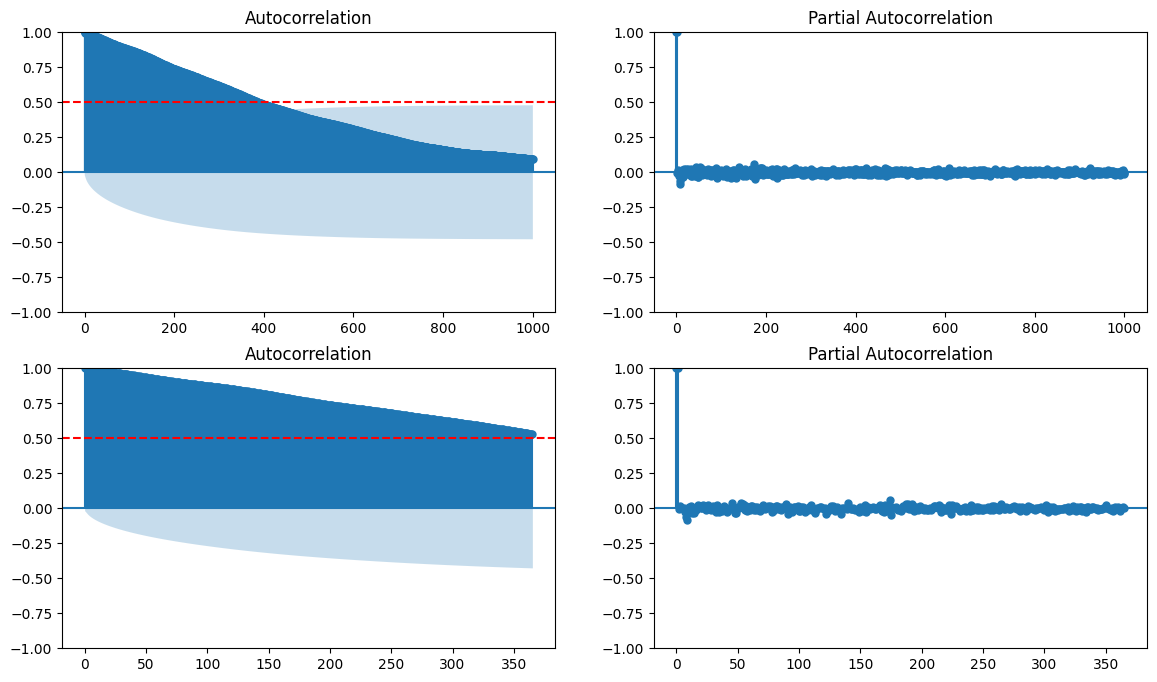

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(df["終値"], ax=ax[0, 0], lags=1000)
ax[0,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[0, 1], lags=1000)

plot_acf(df["終値"], ax=ax[1, 0], lags=365)
ax[1,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[1, 1], lags=365)
plt.show()

In [37]:
m = Prophet()

In [38]:
sampling_term = 20

target = "終値"
sample = df[["日付け",target]]
sample_test = sample.tail(sampling_term)
sample_train = sample.rename(columns={"日付け": "ds", target: "y"}).drop(sample_test.index)
m.fit(sample_train)

22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:21 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = sample_test[["日付け"]].rename(columns={"日付け":"ds"})
forecast = m.predict(future)

In [40]:
y_pred = forecast["yhat"]
y_test = sample_test[target]
mape_score = mean_absolute_percentage_error(y_pred,y_test)
print(f"MAPE : {mape_score *100:.3f} %")

MAPE : 4.438 %


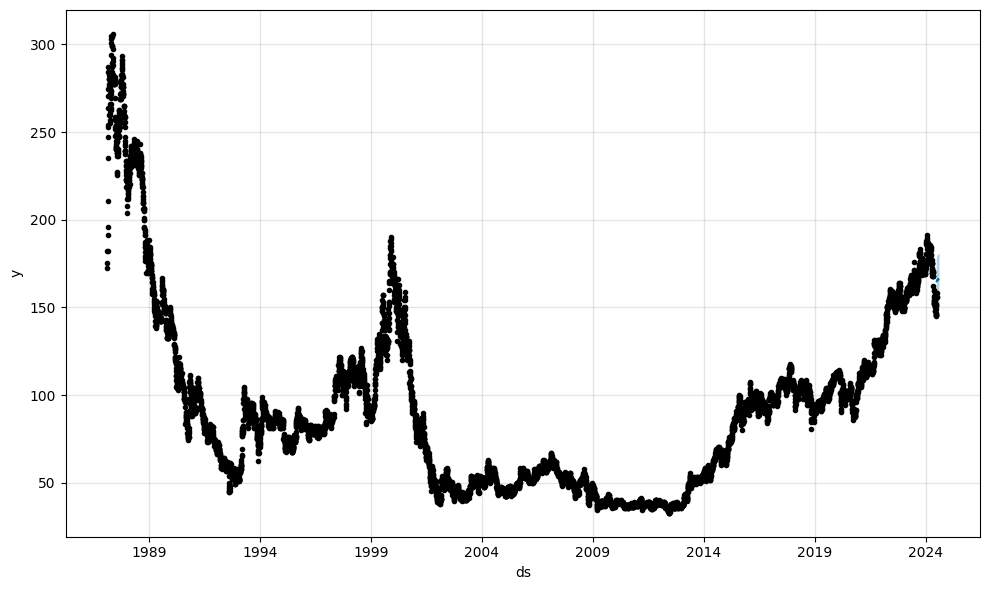

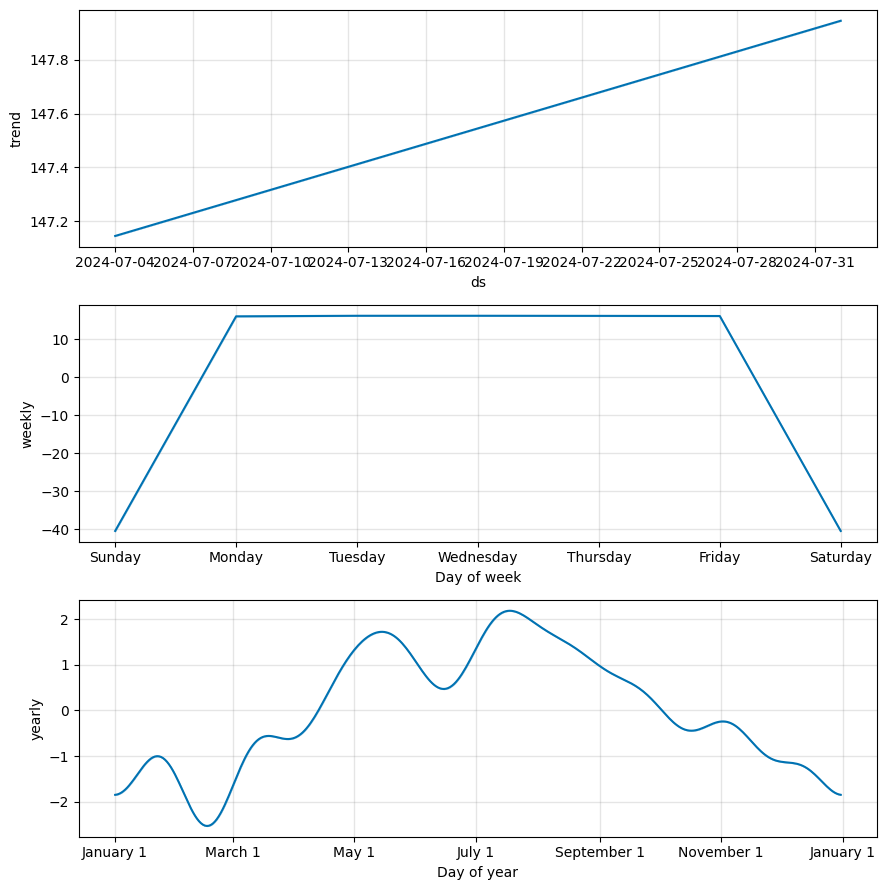

In [41]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


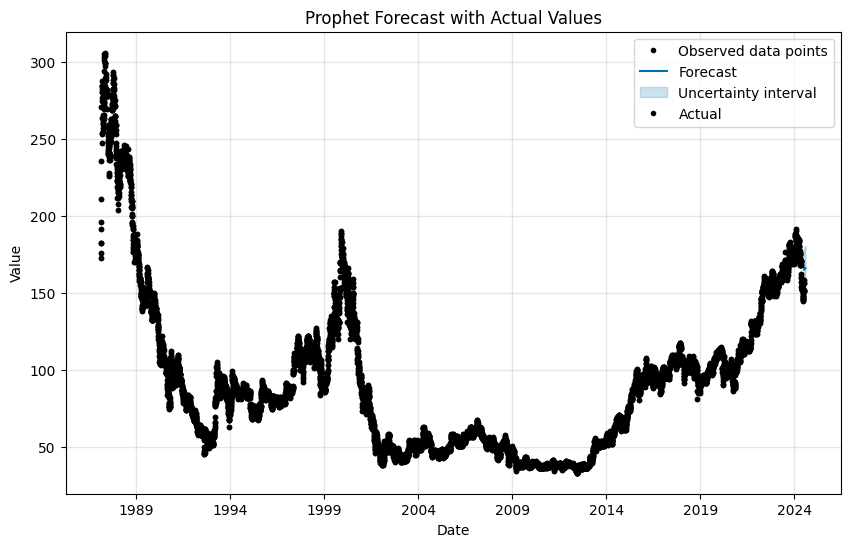

In [42]:
import matplotlib.pyplot as plt

# 実測値と予測値を重ねてプロットする関数
def plot_forecast_with_actual(m, forecast, actual_data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # 予測値をプロット
    m.plot(forecast, ax=ax)
    
    # 実測値をプロット
    ax.plot(actual_data['ds'], actual_data['y'], 'k.', label='Actual')
    
    # 凡例を追加
    ax.legend()
    ax.set_title('Prophet Forecast with Actual Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    
    return ax

# 例: 訓練データと予測を重ねて表示
plot_forecast_with_actual(m, forecast, sample_train)
plt.show()

